## Multilabel Classification

In [739]:
from robingrad import Tensor, draw_dot
import robingrad.nn as nn
from robingrad.optim import SGD, Adam
from robingrad.state import get_parameters
import pandas as pd
import numpy as np 
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import time 

### Dataset

In [740]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print(X.shape)
print(type(X))
print(y.shape)
print(type(y))
num_classes = len(np.unique(y))
print(num_classes)

(150, 4)
<class 'numpy.ndarray'>
(150,)
<class 'numpy.ndarray'>
3


In [741]:
X = pd.DataFrame(X, columns=iris.feature_names)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [742]:
y = pd.Series(y)
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [743]:
encoder = OneHotEncoder(sparse_output=False)
y_ohe = encoder.fit_transform(y.values.reshape(-1, 1))

In [744]:

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(120, 4)
(30, 4)
(120, 3)
(30, 3)


In [745]:
X_train_scaled = np.where(X_train_scaled == 0, 0.01, X_train_scaled)
X_train_scaled = np.where(X_train_scaled > 0.99, 0.99, X_train_scaled)
X_train_scaled

array([[0.08823529, 0.66666667, 0.01      , 0.04166667],
       [0.41176471, 0.99      , 0.0877193 , 0.125     ],
       [0.70588235, 0.45833333, 0.59649123, 0.54166667],
       [0.14705882, 0.58333333, 0.10526316, 0.04166667],
       [0.02941176, 0.5       , 0.05263158, 0.04166667],
       [0.58823529, 0.20833333, 0.70175439, 0.75      ],
       [0.61764706, 0.5       , 0.61403509, 0.58333333],
       [0.26470588, 0.625     , 0.0877193 , 0.04166667],
       [0.20588235, 0.66666667, 0.07017544, 0.04166667],
       [0.26470588, 0.875     , 0.0877193 , 0.01      ],
       [0.44117647, 0.29166667, 0.71929825, 0.75      ],
       [0.5       , 0.58333333, 0.61403509, 0.625     ],
       [0.70588235, 0.45833333, 0.64912281, 0.58333333],
       [0.32352941, 0.79166667, 0.05263158, 0.125     ],
       [0.32352941, 0.70833333, 0.0877193 , 0.04166667],
       [0.35294118, 0.16666667, 0.47368421, 0.375     ],
       [0.58823529, 0.33333333, 0.71929825, 0.58333333],
       [0.61764706, 0.45833333,

In [746]:
X_train_tensor = Tensor(X_train_scaled, requires_grad=True)
print(type(X_train_tensor), X_train_tensor.shape)
y_train_tensor = Tensor(y_train, requires_grad=True)
print(type(y_train_tensor), y_train_tensor.shape)

<class 'robingrad.tensor.Tensor'> (120, 4)
<class 'robingrad.tensor.Tensor'> (120, 3)


In [747]:
class RobinNet:
    def __init__(self):
        self.l1 = nn.Linear(4, 16)
        self.l2 = nn.Linear(16, 16)
        self.l3 = nn.Linear(16, 3)
    def __call__(self, x):
        x = self.l1(x)
        x = x.sigmoid()
        x = self.l2(x)
        x = x.sigmoid()
        x = self.l3(x)
        return x
model = RobinNet()
params = get_parameters(model)
opt = Adam(params, lr=0.001)

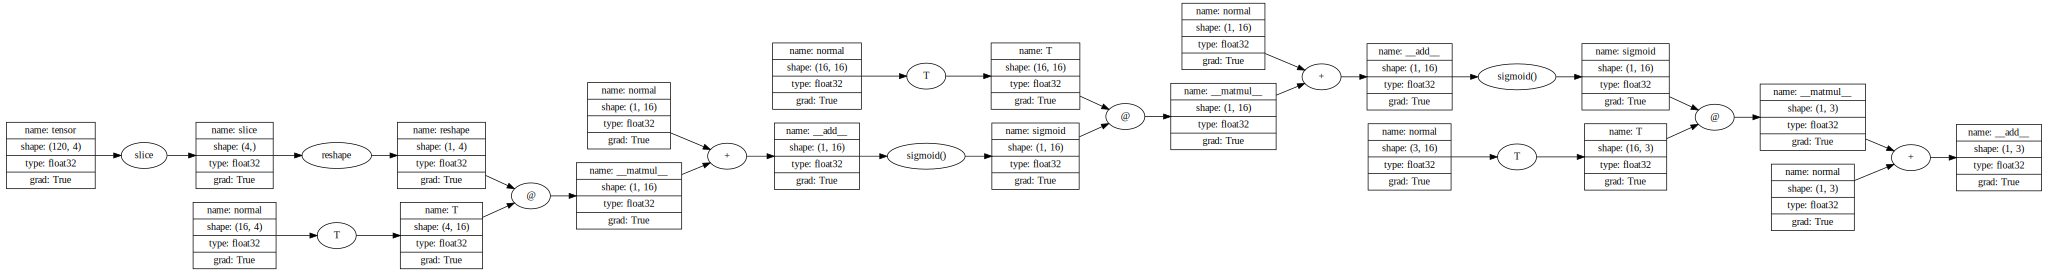

In [748]:
result = model(X_train_tensor[0].reshape((1,4)))
draw_dot(result)

In [749]:
def gradient_clipping(params):
    for param in params:
        param.data = np.clip(param.grad, -10, 10)

In [750]:
def cross_entropy_loss(forward_array, target):
    epsilon = 1e-5
    exp_forward = forward_array.exp()
    norm_term = Tensor.full_like(exp_forward, fill_value=exp_forward.sum().data, requires_grad=True)
    softmax_vec = exp_forward / (norm_term + epsilon)
    neg_output = 1 - softmax_vec
    try:
        bce_losses = -(target * softmax_vec.log() + (1 - target) * neg_output.log())
        BCELoss = bce_losses.sum()
        y_pred = softmax_vec.data.tolist()[0].index(max(softmax_vec.data.tolist()[0]))
        return BCELoss, y_pred
    except Exception as e:
        print(f"Error: {e}")
        
        print(f"forward_array: {forward_array.data}")
        print(f"exp_forward: {exp_forward.data}")
        print(f"norm_term: {norm_term.data}")
        print(f"softmax_vec: {softmax_vec.data}")
        print(f"neg_output: {neg_output.data}")
        return None, None


In [751]:
def accuracy_val(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = encoder.inverse_transform(y_true).reshape(-1)
    correct_results = np.sum(y_pred == y_true)
    acc = correct_results/y_true.shape[0]
    acc = np.round(acc * 100)
    return acc

In [752]:
epochs = 100
for epoch in range(epochs):
    y_pred = []
    losses = []
    s = time.monotonic()
    for i in range(X_train_tensor.shape[0]):
        output = model(X_train_tensor[i].reshape((1,4)))
        loss, y_pred_i = cross_entropy_loss(output, y_train_tensor[i].reshape((1,3)))
        losses.append(loss.data)
        y_pred.append(y_pred_i)
        opt.zero_grad()
        loss.backward()
        opt.step()
        # gradient_clipping(params)
    e = time.monotonic()
    t = e - s
    acc = accuracy_val(y_pred=y_pred, y_true=y_train)
    loss_epoch = sum(losses)/len(losses)
    if epoch % 10 == 0 or epoch==(epochs-1):
        print(f"epoch: {epoch} | loss: {loss_epoch:.2f} | time: {t:.2f} sec. | acc: {acc:.2f}%")

epoch: 0 | loss: 2.29 | time: 0.13 sec. | acc: 34.00%


epoch: 10 | loss: 1.02 | time: 0.11 sec. | acc: 97.00%
epoch: 20 | loss: 0.93 | time: 0.10 sec. | acc: 90.00%
epoch: 30 | loss: 0.93 | time: 0.09 sec. | acc: 96.00%
epoch: 40 | loss: 0.92 | time: 0.10 sec. | acc: 97.00%
epoch: 50 | loss: 0.95 | time: 0.10 sec. | acc: 96.00%
epoch: 60 | loss: 0.96 | time: 0.09 sec. | acc: 95.00%
epoch: 70 | loss: 1.02 | time: 0.09 sec. | acc: 93.00%
epoch: 80 | loss: 0.90 | time: 0.13 sec. | acc: 73.00%
epoch: 90 | loss: 0.78 | time: 0.11 sec. | acc: 94.00%
epoch: 99 | loss: 0.83 | time: 0.09 sec. | acc: 97.00%
